In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname, ''))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/


In [2]:
!pip install git+https://github.com/Farama-Foundation/MAgent2
!git clone https://github.com/sambt22022517/BTL-RL.git

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-8d3cssph
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-8d3cssph
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 101.2 MB/s eta 0:00:00
  Created wheel for magent2: filename=magent2-0.3.3-cp310-cp310-linux_x86_64.whl size=1696102 sha256=78c2371abf8516118b499801f190126b5e73a8590d941861afff907156182514
  Stored in directory: /tmp/pip-ephem-wheel-cache-4jhhzki3/wheels/e4/8e/bf/51a30bc4038546e23b81c9fb513fe6a8fd916e5a9c5f4291d5
Successfully built magent2
Cloning into 'BTL-RL'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.

## Import module

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from magent2.environments import battle_v4
import cv2
from collections import deque
import time
import random
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import FileLink
import warnings
warnings.filterwarnings('ignore')

## Config

In [4]:
# Global config
SEED = 42
env = battle_v4.env(map_size=45, render_mode="rgb_array")
observation_shape = env.observation_space("red_0").shape
action_shape = env.action_space("red_0").n
episodes = 20
batch_size = 2**10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Pretrain Model
pretrain_model_params = {
    'observation_shape': observation_shape,
    'action_shape': action_shape,
    'device': device,
}
pretrain_params = '/kaggle/working/BTL-RL/experiment/sam/v1/v1.pth'
# pretrain_params = '/kaggle/working/BTL-RL/result/v0/red.pt'

# Model
model_params = {
    'observation_shape': observation_shape,
    'action_shape': action_shape,
    'device': device,
}

# Trainer
optim_params = {
    'lr': 1e-3,
    'weight_decay': 0.0,
}
scheduler_params = {
    'T_max': episodes,
    'eta_min': 1e-6,
}
trainer_params = {
    'action_shape': action_shape,
    'epsilon': 1.0,
    'epsilon_min': 0.01,
    'epsilon_beta': 0.92, 
    'weight_init': True,
    'custom_weight_initializer': None,
    'device': device,
}

# training
train_func_params = {
    'episodes': episodes,
    'batch_size': batch_size,
    'gamma': 0.9,
    'env': env,
    'eval_opponent_net': 'pretrain', 
    'update_tgt_net_frequence': 1,
    'update_tgt_net_rate': 0.3,
    'update_eva_net_frequence': 4, 
    'detect_best_model_by': 'val',
    'start_detect_best_model_at_episode': 5, 
    'save_at_end': True,
    'save_only_network': True,
    'save_name': f'{episodes}-{batch_size}.pth',
}

# Memory
memory_params = {
    'maxlen': 162 * episodes,
}

# Eval Policy
_eval_policy_params = {
    'env': env,
    'opponent_net': train_func_params['eval_opponent_net'],
}

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Data

In [6]:
class Memory(Dataset):
    def __init__(self, maxlen):
        super().__init__()
        self.maxlen = maxlen
        self.step_memory = [deque(maxlen=self.maxlen)]
    
    def push(self, memory_idx, state, action, reward, next_state, done):
        if memory_idx == len(self.step_memory):
            self.step_memory.append(deque(maxlen=self.maxlen))
        self.step_memory[memory_idx].append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        memory_idxes = np.empty(0, dtype=int)
        while batch_size >= len(self.step_memory):
            memory_idxes = np.concatenate((memory_idxes, np.arange(len(self.step_memory))), axis=0)
            batch_size -= len(self.step_memory)
        if batch_size > 0:
            memory_idxes = np.concatenate((memory_idxes, np.random.choice(len(self.step_memory), batch_size, replace=False)), axis=0)

        batch = []
        for idx in memory_idxes:
            data_idx = np.random.choice(len(self.step_memory[idx]), 1)[0]
            batch.append(self.step_memory[idx][data_idx])
            
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state),
            torch.tensor(action),
            torch.tensor(reward, dtype=torch.float),
            torch.tensor(next_state),
            torch.tensor(done, dtype=torch.float32),
        )
    
    def __len__(self):
        return sum([len(memory) for memory in self.step_memory])

    def __getitem__(self, idx):
        memory_idx = 0
        while idx >= len(self.step_memory[memory_idx]):
            idx -= len(self.step_memory[memory_idx])
            memory_idx += 1
        state, action, reward, next_state, done = self.step_memory[memory_idx][idx]
        return (
            torch.tensor(state),
            torch.tensor(action),
            torch.tensor(reward, dtype=torch.float),
            torch.tensor(next_state),
            torch.tensor(done, dtype=torch.float32),
        )
    
    def getMemoryLength(self, idx):
        return len(self.step_memory[idx])
    
    def getAllMemoryLength(self):
        return [len(memory) for memory in self.step_memory]
    
    def getNumMemory(self):
        return len(self.step_memory)

In [7]:
train_memory = Memory(**memory_params)

## Pretrain Model

In [8]:
class PretrainQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape, device='cpu'):
        super().__init__()
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.device = device
        
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3),
            nn.ReLU(),
        )
        
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        x = x.to(self.device)
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)

## Model

In [9]:
class QNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape, device='cpu'):
        super().__init__()
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.device = device
        
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3),
            nn.ReLU(),
        )
        
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        x = x.to(self.device)
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)

## Trainer

In [10]:
class Trainer:
    def __init__(
        self, 
        policy_net, target_net, evalua_net, pretrain_net, 
        lossfunc, optimizer, scheduler, 
        action_shape, 
        epsilon=1.0, epsilon_min=0.01, epsilon_beta=0.995, 
        pretrain_rate=1, pretrain_beta=0.9, 
        weight_init=True, custom_weight_initializer=None, 
        device='cpu'
    ):
        
        self.policy_net = policy_net.to(device)
        self.target_net = target_net.to(device)
        self.target_net.eval()
        self.evalua_net = evalua_net.to(device)
        self.evalua_net.eval()
        self.pretrain_net = pretrain_net.to(device)
        self.pretrain_net.eval()
        
        self.lossfuncs = lossfunc
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.action_shape = action_shape
        
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_beta = epsilon_beta
        
        self.weight_init = weight_init
        self.custom_weight_initializer = custom_weight_initializer

        self.device = device
        
        self.save_best_model = False
        
        if self.weight_init:
            if self.custom_weight_initializer:
                self.policy_net.apply(self.custom_weight_initializer)
            else:
                self.policy_net.apply(self.xavier_init_weight)
                
    def xavier_init_weight(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if torch.is_tensor(m.bias):
                m.bias.data.fill_(0.01)
    
    def save_model(self, dirname='/kaggle/working/model_params', filename='full_model.pth', only_network=False):
        if not os.path.isdir(dirname):
            os.mkdir(dirname)
        state_dicts = {
            'network_params': self.policy_net.state_dict(),
            'scheduler_params': self.scheduler.state_dict(),
            'optimizer_params': self.optimizer.state_dict(),
        }
        if only_network:
            return torch.save(self.policy_net.state_dict(), os.path.join(dirname, filename))
        return torch.save(state_dicts, os.path.join(dirname, filename))
    
    def load_model(self, dirname='/kaggle/working/model_params', filename='full_model.pth'):
        best_model_path = f'{dirname}/{filename}'
        if os.path.exists(best_model_path):
            try:
                best_model_state = torch.load(best_model_path, weights_only=True, map_location=self.device)['network_params']
            except:
                best_model_state = torch.load(best_model_path, weights_only=True, map_location=self.device)
            self.policy_net.load_state_dict(best_model_state)
            print(f'Model is loaded from {best_model_path}')
        else:
            print(f'Model is not exist at {best_model_path}')

    def epsilon_greedy_policy(self, observation, only_random=False):
        if not only_random:
            if np.random.rand() < self.epsilon:
                return np.random.randint(low=0, high=self.action_shape)
            else:
                observation = torch.FloatTensor(observation).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    return self.policy_net(observation).squeeze().argmax().item()
        return np.random.randint(low=0, high=self.action_shape)
                
    def _train_policy_net(self, train_memory, batch_size, gamma):
        # Tạo train loader
        train_loader = DataLoader(train_memory, batch_size=batch_size, shuffle=True)
        self.policy_net.train()
        for observations, actions, rewards, next_observations, dones in train_loader:
            self.policy_net.zero_grad()
            
            observations = observations.to(self.device)
            actions = actions.unsqueeze(1).to(self.device)
            rewards = rewards.unsqueeze(1).to(self.device)
            next_observations = next_observations.to(self.device)
            dones = dones.unsqueeze(1).to(self.device)
            
            # Tính giá trị Q mục tiêu
            with torch.no_grad():
                target_q_values = rewards + gamma * (1 - dones) * self.target_net(next_observations).max(1, keepdim=True)[0]
            
            # Tính giá trị Q hiện tại
            current_q_values = self.policy_net(observations).gather(1, actions)
            
            # Compute loss
            loss = self.lossfuncs(current_q_values, target_q_values)
            
            # Optimize the network
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

    def _eval_policy_net(self, env, opponent_net):
        self.policy_net.eval()
        result = []
        T_result = []

        # Xác định đối thủ
        if opponent_net == 'target':
            opponent_net = self.target_net
        elif opponent_net == 'pretrain':
            opponent_net = self.pretrain_net
        else:
            opponent_net = self.evalua_net

        model = {'red': self.policy_net, 'blue': opponent_net}
        with torch.no_grad():
            for turn in range(2): # Đánh giá ở cả 2 bên đỏ và xanh
                T = 0
                red_reward = 0
                blue_reward = 0                
                env.reset()
                for agent in env.agent_iter():
                    T += 1
                    observation, reward, termination, truncation, info = env.last()
                    observation = np.transpose(observation, (2, 0, 1))
                    observation = torch.FloatTensor(observation).unsqueeze(0).to(self.device)

                    # Chọn hành động
                    if 'red' in agent:
                        red_reward += reward
                        if termination or truncation:
                            action = None
                        else:
                            action = model['red'](observation).squeeze().argmax().item()
                    else:
                        blue_reward += reward
                        if termination or truncation:
                            action = None
                        else:
                            action = model['blue'](observation).squeeze().argmax().item()
                    env.step(action)

                # Lưu lại kết quả
                if turn == 0:
                    result.append(red_reward - blue_reward)
                else:
                    result.append(blue_reward - red_reward)
                T_result.append(T)
                
                model = {'blue': self.policy_net, 'red': opponent_net} # Đổi bên
                
        # Lấy min để trả về, nếu min > 0 thì tức cả 2 đều rất Ok và ngược lại thì ít nhất có 1 bên không ổn, không lấy.        
        over_result = min(result)
        T_result = T_result[result.index(over_result)]
        speed_val_reward = over_result / T_result * 1000
        return speed_val_reward, T_result
    
    def train(self, 
              train_memory, episodes, batch_size, gamma, env, 
              eval_opponent_net='evalua', 
              update_tgt_net_frequence=10, update_tgt_net_rate=0.005, 
              update_eva_net_frequence=4, 
              detect_best_model_by='train', 
              start_detect_best_model_at_episode=5, 
              save_at_end=False, save_only_network=False, save_name='full_model.pth',
             ):
        all_train_rewards = []
        all_T_train = []
        all_val_rewards = []
        all_T_val = []
        saved = []
        max_reward = float('-inf')
    
        for episode in range(episodes):
            total_train_reward = {'red': 0, 'blue': 0}
            T = 0
            agent_POV_is_red = (np.random.rand() >= 0.5)
            prev_observations = {}
            prev_actions = {}
            memory_idx = {}
            
            env.reset()
            for idx, agent in enumerate(env.agent_iter()):
                T += 1
                prev_observation, reward, termination, truncation, _ = env.last()
                prev_observation = np.transpose(prev_observation, (2, 0, 1))
                if 'red' in agent:
                    total_train_reward['red'] += reward
                else:
                    total_train_reward['blue'] += reward
                prev_action = self.epsilon_greedy_policy(prev_observation)

                memory_idx[agent] = 0
                prev_observations[agent] = prev_observation
                prev_actions[agent] = prev_action
                env.step(prev_action)     
                
                if (idx+1) % env.num_agents == 0:
                    break
                    
            for agent in env.agent_iter():
                T += 1
                
                # Từ trạng thái trước, thực hiện hành động để lấy trạng thái hiện tại
                observation, reward, termination, truncation, _ = env.last()
                observation = np.transpose(observation, (2, 0, 1))

                # Đánh giá phần thưởng của trận đấu
                if 'red' in agent:
                    total_train_reward['red'] += reward
                else:
                    total_train_reward['blue'] += reward

                # Nếu agent chết rồi thì hành động chọn là None
                if termination or truncation:
                    action = None
                else:
                    action = self.epsilon_greedy_policy(observation)
                
                # Thêm bộ (S, A, R+, S+, terminal?) vào bộ nhớ để training
                train_memory.push(
                    memory_idx[agent],
                    prev_observations[agent], 
                    prev_actions[agent], 
                    reward, 
                    observation, 
                    termination
                )

                memory_idx[agent] += 1
                prev_observations[agent] = observation
                prev_actions[agent] = action
                env.step(action)

            # Training mô hình với memory hiện tại
            self._train_policy_net(train_memory, batch_size, gamma)
                
            # Đánh giá model, phần thưởng thu được càng lớn thì càng tốt
            speed_train_reward = (total_train_reward['red'] - total_train_reward['blue']) / T * 1000
            speed_val_reward, T_val = self._eval_policy_net(env, opponent_net=eval_opponent_net)
            
            # Cập nhật lại mô hình mục tiêu theo chu kì
            if episode % update_tgt_net_frequence == 0:
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*update_tgt_net_rate + target_net_state_dict[key]*(1-update_tgt_net_rate)
                self.target_net.load_state_dict(target_net_state_dict)
            
            # Cập nhật lại mô hình đánh giá theo chu kì
            if episode % update_eva_net_frequence == 0:
                self.evalua_net.load_state_dict(self.policy_net.state_dict())

            # Lưu lại model nếu kết quả tốt
            if detect_best_model_by is not None:
                if detect_best_model_by == 'train':
                    model_reward = speed_train_reward
                elif detect_best_model_by == 'val':
                    model_reward = speed_val_reward
                    
                if model_reward > max_reward and episode >= start_detect_best_model_at_episode:
                    max_reward = model_reward
                    self.save_model(filename=save_name, only_network=save_only_network)
                    self.save_best_model = True
                    saved.append(1)
                else:
                    saved.append(0)
            else:
                saved.append(0)
        
            # Cập nhật lại epsilon, do càng train thì mô hình càng tốt, từ đó ít cần khám phá hơn
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_beta)

            # Logging
            print(f"Episode {episode + 1}, Speed Train: {speed_train_reward}, T Train: {T}, Speed Val: {speed_val_reward}, T Val: {T_val}")

            all_train_rewards.append(speed_train_reward)
            all_val_rewards.append(speed_val_reward)
            all_T_train.append(T)
            all_T_val.append(T_val)

        if not self.save_best_model or save_at_end:
            self.save_model(filename=f'save-at-end {save_name}', only_network=save_only_network)
            self.save_best_model = True
            saved[-1] = 1
        return all_train_rewards, all_T_train, all_val_rewards, all_T_val, saved

## Training Model

In [11]:
policy_net = QNetwork(**model_params)

target_net = QNetwork(**model_params)
target_net.load_state_dict(policy_net.state_dict())

evalua_net = QNetwork(**model_params)
evalua_net.load_state_dict(policy_net.state_dict())

pretrain_net = PretrainQNetwork(**pretrain_model_params)
pretrain_net.load_state_dict(
    torch.load(pretrain_params, weights_only=True, map_location=device)
)

<All keys matched successfully>

In [12]:
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(policy_net.parameters(), **optim_params)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, **scheduler_params)

In [13]:
trainer = Trainer(
    policy_net, target_net, evalua_net, pretrain_net, 
    loss_function, optimizer, lr_scheduler, 
    **trainer_params
)

In [14]:
start_time = time.time()
val_reward = trainer._eval_policy_net(**_eval_policy_params)
print('Val Reward: ', val_reward)
print("--- %s seconds ---" % (time.time() - start_time))

Val Reward:  (-50.22258513512578, 19049)
--- 14.267715692520142 seconds ---


In [15]:
start_time = time.time()
all_train_rewards, all_T_train, all_val_rewards, all_T_val, saved = trainer.train(train_memory, **train_func_params)
print("--- %s seconds ---" % (time.time() - start_time))

Episode 1, Speed Train: -0.13206134142731116, T Train: 161478, Speed Val: -32.97885804234229, T Val: 12629
Episode 2, Speed Train: 0.4078854079487084, T Train: 160474, Speed Val: -0.348027343759423, T Val: 62021
Episode 3, Speed Train: 4.434041400079222, T Train: 114761, Speed Val: 0.004062647514362802, T Val: 156302
Episode 4, Speed Train: 2.0890553713751774, T Train: 53596, Speed Val: -18.292535540099717, T Val: 15728
Episode 5, Speed Train: 0.5020875386771004, T Train: 106346, Speed Val: -38.839738123302894, T Val: 10851
Episode 6, Speed Train: 7.856307005343104, T Train: 86274, Speed Val: -39.716308320614175, T Val: 9958
Episode 7, Speed Train: 5.94439528864413, T Train: 68573, Speed Val: -28.650037591162576, T Val: 10604
Episode 8, Speed Train: 5.205718907133664, T Train: 49242, Speed Val: -29.818641559430652, T Val: 9291
Episode 9, Speed Train: -3.31276795415628, T Train: 28203, Speed Val: -37.97080274943235, T Val: 7535
Episode 10, Speed Train: 4.926226453296708, T Train: 16876,

In [16]:
if trainer.save_best_model:
    trainer.load_model(filename=train_func_params['save_name'])
trainer.policy_net

Model is loaded from /kaggle/working/model_params/20-1024.pth


QNetwork(
  (cnn): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (network): Sequential(
    (0): Linear(in_features=405, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=21, bias=True)
  )
)

In [17]:
start_time = time.time()
val_reward = trainer._eval_policy_net(**_eval_policy_params)
print('Val Reward: ', val_reward)
print("--- %s seconds ---" % (time.time() - start_time))

Val Reward:  (0.06403249818518997, 122594)
--- 74.9605233669281 seconds ---


## Visualize

In [18]:
training_log = {
    'Episode': list(range(1, len(all_train_rewards)+1)),
    'Train Reward': all_train_rewards, 
    'Eval Reward': all_val_rewards, 
    'T Train': all_T_train, 
    'T Eval': all_T_val, 
    'Saved': saved
}
df = pd.DataFrame(training_log)

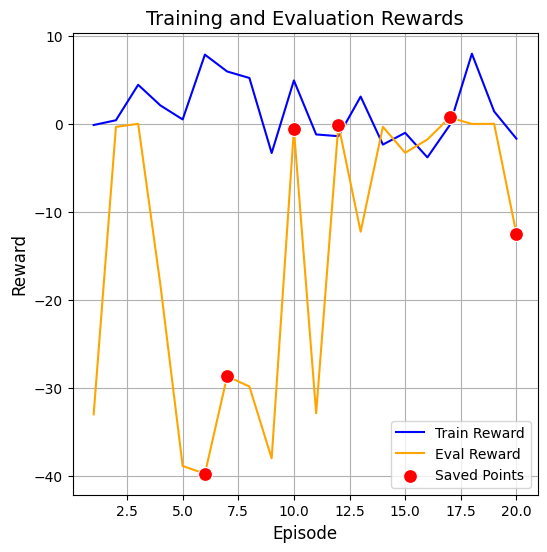

In [19]:
plt.figure(figsize=(6, 6))

sns.lineplot(data=df, x='Episode', y='Train Reward', label='Train Reward', color='blue') # Biểu đồ đường Train Reward
sns.lineplot(data=df, x='Episode', y='Eval Reward', label='Eval Reward', color='orange') # Biểu đồ đường Eval Reward

dfy = 'Eval Reward' if train_func_params['detect_best_model_by'] == 'val' else 'Train Reward'
saved_points = df[df['Saved'] == 1]
sns.scatterplot(data=saved_points, x='Episode', y=dfy, color='red', label='Saved Points', s=100, zorder=5) # Đánh dấu các điểm Saved = 1

# Thêm tiêu đề và chú thích
plt.title('Training and Evaluation Rewards', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

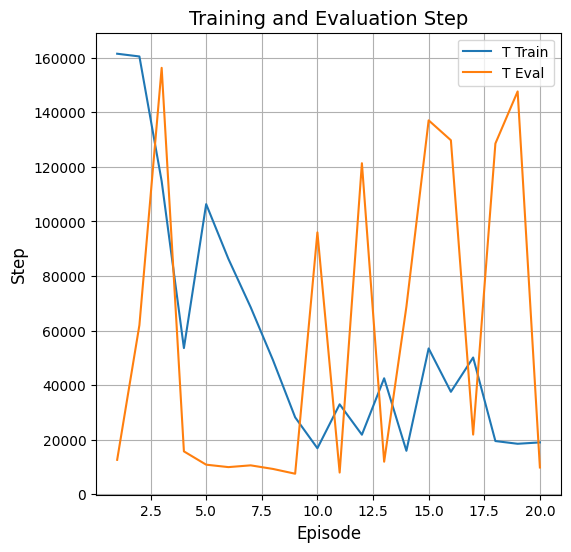

In [20]:
plt.figure(figsize=(6, 6))

sns.lineplot(data=df, x='Episode', y='T Train', label='T Train') # Biểu đồ đường T Train
sns.lineplot(data=df, x='Episode', y='T Eval', label='T Eval') # Biểu đồ đường T Eval

# Thêm tiêu đề và chú thích
plt.title('Training and Evaluation Step', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Step', fontsize=12)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()